### <p style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 38px;text-align: center;padding: 12px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(3px);text-shadow: 1px 1px 2px rgba(0, 0, 0, 0.1);transition: all 0.3s ease;">Car Prices</p>

https://www.kaggle.com/competitions/playground-series-s4e9/overview

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Used Car Price Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

- Brand & Model: Identify the brand or company name along with the specific model of each vehicle.
- Model Year: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.
- Mileage: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.
- Fuel Type: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
- Engine Type: Understand the engine specifications, shedding light on performance and efficiency.
- Transmission: Determine the transmission type, whether automatic, manual, or another variant.
- Exterior & Interior Colors: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.
- Accident History: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.
- Clean Title: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.
- Price: Access the listed prices for each vehicle, aiding in price comparison and budgeting.

## <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 24px;padding: 10px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">1. Imports</div>


In [94]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import phik
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

shap.initjs()

In [95]:
retro_palette = [
    "#f4c6c6",  # pastel red
    "#f6b3c1",  # pastel pink
    "#f0b9a4",  # pastel orange
    "#f3e1a0",  # pastel yellow
    "#b7d3a9",  # pastel green
    "#9fc5e8",  # pastel blue
    "#c8a2c8",  # pastel purple
    "#f5f5f5",  # very light gray (neutral)
    "#e0d4d4",  # dusty rose (neutral)
    "#d4e1e6",  # pale blue-gray (neutral)
    "#e3e2d5",  # light beige-gray (neutral)
    "#d9e6c9",  # muted lime (neutral)
    "#d0b9d0",  # pastel lavender (neutral)
    "#c0d9c7",  # muted sage (neutral)
    "#d6c5c5",  # pastel taupe (neutral)
    "#c5d0f0",  # soft sky blue (neutral)
    "#b4d7c1",  # light mint green (neutral)
    "#e0b3b3",  # soft coral (neutral)
    "#e5d7a4",  # pale mustard (neutral)
    "#b4c8e4",  # pastel periwinkle (neutral)
]


colors = ["#c5d0f0", "#e0b3b3"]
cmap = LinearSegmentedColormap.from_list("retro_palette", colors, N=10)

In [96]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [97]:
train.shape

(188533, 13)

In [98]:
test.shape

(125690, 12)

Let's combine train and test for some eda steps

In [99]:
train["is_train"] = "Y"
test["is_train"] = "N"

combined = pd.concat([train, test], ignore_index=True)

In [100]:
combined.shape

(314223, 14)

In [101]:
combined.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Y
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Y
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Y
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Y
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Y


## <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 24px;padding: 10px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">2. EDA</div>

In [102]:
train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
 13  is_train      188533 non-null  object
dtypes: int64(4), object(10)
memory usage: 20.1+ MB


In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
 12  is_train      125690 non-null  object
dtypes: int64(3), object(10)
memory usage: 12.5+ MB


Checking the target

In [105]:
train["price"]

0          4200
1          4999
2         13900
3         45000
4         97500
          ...  
188528    27500
188529    30000
188530    86900
188531    84900
188532    28995
Name: price, Length: 188533, dtype: int64

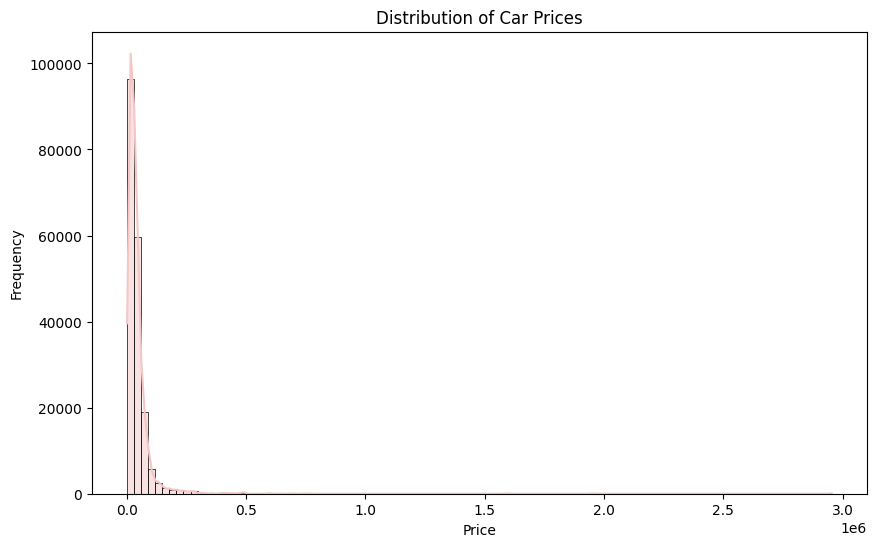

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(train["price"], bins=100, kde=True, color=retro_palette[0])
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The distribution is highly skewed to the left, indicating a long tail on the higher end

We need to look at all features more precisely 

In [107]:
train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'is_train'],
      dtype='object')

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">1. Brand</div>

In [108]:
combined["brand"].isna().sum()

0

In [109]:
combined["brand"].value_counts(dropna=False)

brand
Ford             38353
Mercedes-Benz    32047
BMW              28314
Chevrolet        27033
Audi             18176
Porsche          17765
Land             15873
Toyota           14934
Lexus            14372
Jeep             10886
Cadillac          7733
RAM               7002
Nissan            6604
Tesla             6125
INFINITI          5399
GMC               5309
Dodge             5204
Mazda             4489
Kia               4247
Lincoln           4016
Subaru            3972
Acura             3849
Honda             3537
Hyundai           3353
Volkswagen        2987
Jaguar            2253
Bentley           1944
MINI              1761
Genesis           1612
Buick             1591
Maserati          1558
Lamborghini       1356
Volvo             1299
Chrysler          1241
Alfa              1149
Rivian             980
Rolls-Royce        944
Mitsubishi         918
Pontiac            879
Hummer             862
Ferrari            610
McLaren            408
Aston              382
Satur

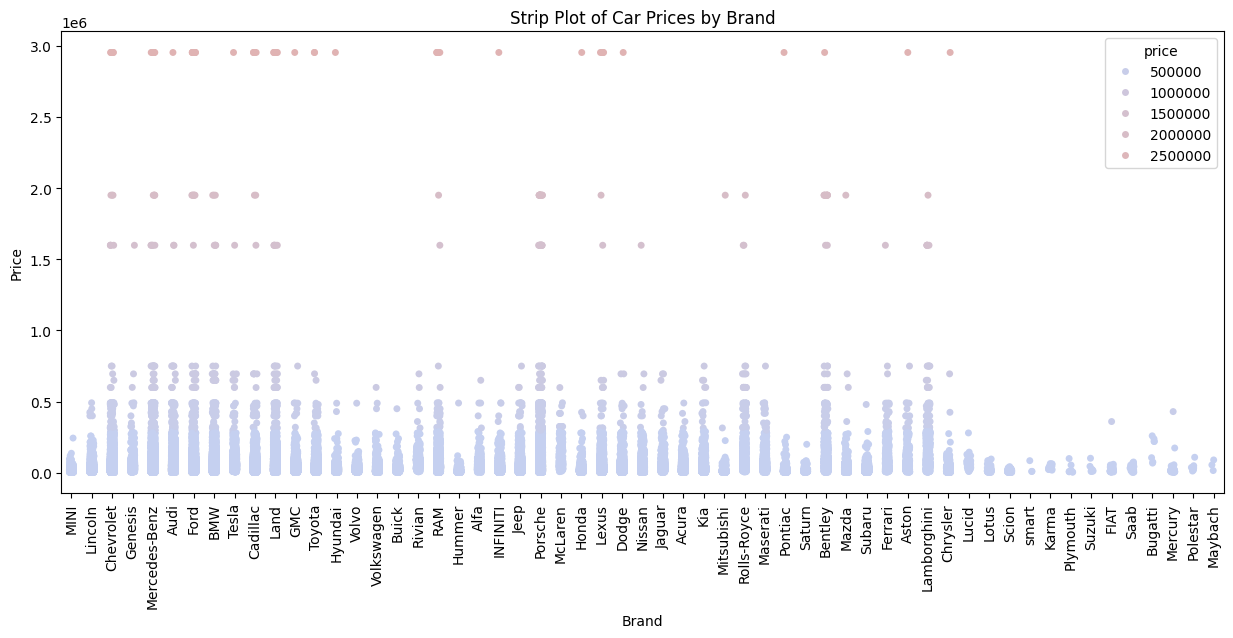

In [110]:
plt.figure(figsize=(15, 6))
sns.stripplot(x="brand", y="price", data=train, jitter=True, hue="price", palette=cmap)
plt.title("Strip Plot of Car Prices by Brand")
plt.xlabel("Brand")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.show()

The feature is categorical

In [111]:
categorical = ["brand"]

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">2. Model</div>

In [112]:
combined["model"].isna().sum()

0

In [113]:
combined["model"].value_counts()

model
F-150 XLT                   4868
M3 Base                     3641
Camaro 2SS                  2820
M4 Base                     2627
Mustang GT Premium          2464
                            ... 
X5 xDrive40e                   2
Forte LX                       2
V60 T6 R-Design Platinum       2
X5 3.0i                        1
allroad 2.7T                   1
Name: count, Length: 1898, dtype: int64

In [114]:
train["model"].value_counts().tail(20)

model
Insight EX                        3
Sportage Plug-In Hybrid X-Line    3
XC60 3.2                          3
X5 eDrive xDrive40e               3
740e xDrive iPerformance          3
Stinger GT                        3
500e Battery Electric             3
370Z NISMO                        3
V60 T6 R-Design Platinum          2
ForTwo Pure                       2
XLR V                             2
X5 3.0si                          2
Forte LX                          2
X3 xDrive35i                      2
X5 xDrive 35i Sport Activity      2
IONIQ Plug-In Hybrid SEL          2
X5 3.0i                           1
X5 xDrive40e                      1
XLR Base                          1
Integra w/A-Spec Tech Package     1
Name: count, dtype: int64

I want to split the first word to make the feature more scaled

In [115]:
combined["model_general"] = combined["model"].apply(lambda x: x.split()[0])
combined["model_general"].value_counts()

model_general
Rover       15910
F-150       10145
911          8806
AMG          8648
Corvette     6726
            ...  
Insight         7
Mirage          7
740e            7
500e            6
ForTwo          3
Name: count, Length: 517, dtype: int64

In [116]:
categorical.append("model_general")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">3. Model year</div>

In [117]:
combined["model_year"].isna().sum()

0

In [118]:
combined["model_year"].value_counts().head(20)

model_year
2021    30234
2018    27559
2020    26565
2022    26163
2019    25393
2016    22758
2017    21208
2015    18925
2023    14552
2014    13964
2013    11465
2011    10497
2012    10310
2008     8534
2007     8224
2010     7038
2005     5234
2006     4722
2009     4595
2004     4183
Name: count, dtype: int64

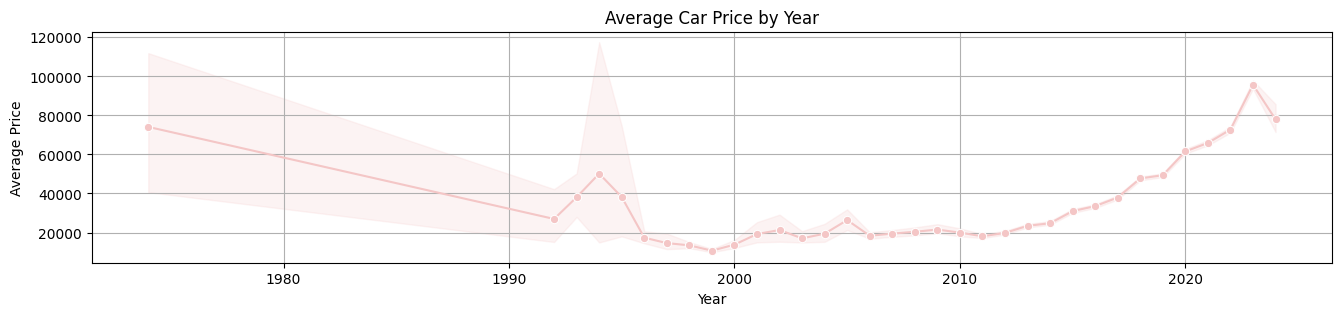

In [119]:
plt.figure(figsize=(16, 3))
sns.lineplot(x="model_year", y="price", data=train, marker="o", color=retro_palette[0])
plt.title("Average Car Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()

In [120]:
train[train["model_year"] < 1990]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train
8173,8173,Dodge,Challenger R/T Scat Pack,1974,49000,–,–,5-Speed M/T,Green,Gray,None reported,Yes,29900,Y
38565,38565,Ford,Bronco,1974,38012,–,–,–,Thunder Gray,Dark Gray,None reported,Yes,84620,Y
47488,47488,Ford,Bronco,1974,109762,Gasoline,–,–,Tempest,–,NaN,NaN,13046,Y
47837,47837,Ford,Bronco XLT,1974,5856,–,–,6-Speed M/T,Black,Black,None reported,Yes,115000,Y
55169,55169,Ford,Thunderbird Deluxe,1974,174678,Gasoline,280.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Beige,None reported,Yes,29998,Y
60702,60702,Porsche,911 Carrera 4S,1974,102750,–,–,A/T,Gray,Gray,None reported,Yes,29000,Y
71389,71389,Ford,Bronco XLT,1974,54323,–,–,4-Speed A/T,Blue,Beige,None reported,Yes,23500,Y
121193,121193,Ford,Bronco,1974,7900,–,–,–,Gray,Gray,None reported,Yes,197499,Y
127656,127656,Lincoln,Town Car Base,1974,152000,–,–,A/T,White,Beige,None reported,Yes,9999,Y
133985,133985,Jaguar,F-PACE S,1974,58356,–,–,Automatic,Black,Ebony,None reported,NaN,115998,Y


In [121]:
numeral = ["model_year"]

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">4. Milage</div>

In [122]:
combined["milage"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 314223 entries, 0 to 314222
Series name: milage
Non-Null Count   Dtype
--------------   -----
314223 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


In [123]:
combined["milage"].describe()

count    314223.000000
mean      65840.210567
std       49969.067924
min         100.000000
25%       24213.000000
50%       57690.000000
75%       95500.000000
max      405000.000000
Name: milage, dtype: float64

In [124]:
combined[combined["milage"] > 350000].head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train,model_general
4051,4051,Toyota,Sequoia TRD Pro,2007,354000,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Brown,Beige,None reported,Yes,8000.0,Y,Sequoia
17186,17186,Mercedes-Benz,E-Class E 550,2016,399000,Gasoline,402.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Gray,Black,None reported,Yes,26500.0,Y,E-Class
19033,19033,Mercedes-Benz,Sprinter 2500,2016,399000,Diesel,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel,A/T,Gold,Gray,None reported,Yes,25500.0,Y,Sprinter
24014,24014,Ford,F-150 XLT,2018,405000,E85 Flex Fuel,385.0HP 5.0L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,35000.0,Y,F-150
27194,27194,Mercedes-Benz,Sprinter High Roof,2014,399000,Diesel,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel,7-Speed A/T,Black,Gray,None reported,Yes,25990.0,Y,Sprinter
33925,33925,Chevrolet,Tahoe LT,2010,399000,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,39990.0,Y,Tahoe
34176,34176,BMW,335 i xDrive,2015,399000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Beige,At least 1 accident or damage reported,Yes,26950.0,Y,335
36080,36080,Chevrolet,Camaro 1SS,2019,405000,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Orange,Black,None reported,Yes,71950.0,Y,Camaro
45077,45077,Toyota,Tacoma TRD Sport,2018,405000,Gasoline,278.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,30000.0,Y,Tacoma
45288,45288,Toyota,Tacoma TRD Sport,2018,405000,Gasoline,278.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,20995.0,Y,Tacoma


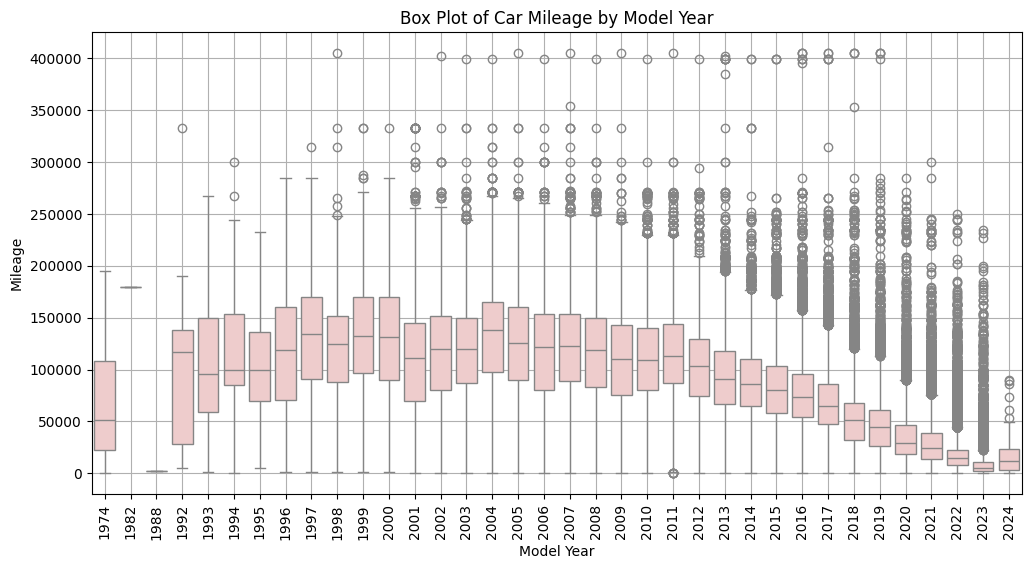

In [125]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="model_year", y="milage", data=combined, color=retro_palette[0])
plt.title("Box Plot of Car Mileage by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Mileage")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

All these extreme milage look suspicious. Let's make them median according to the year.

In [126]:
combined["median_milage"] = combined.groupby("model_year")["milage"].median()


combined["milage"] = combined.apply(
    lambda row: (
        row["median_milage"]
        if row["milage"] > 300000 and row["model_year"] > 2000
        else row["milage"]
    ),
    axis=1,
)

combined.drop(columns=["median_milage"], inplace=True)

combined["milage"].describe()

count    314127.000000
mean      65750.285604
std       49706.515096
min         100.000000
25%       24213.000000
50%       57550.000000
75%       95450.000000
max      405000.000000
Name: milage, dtype: float64

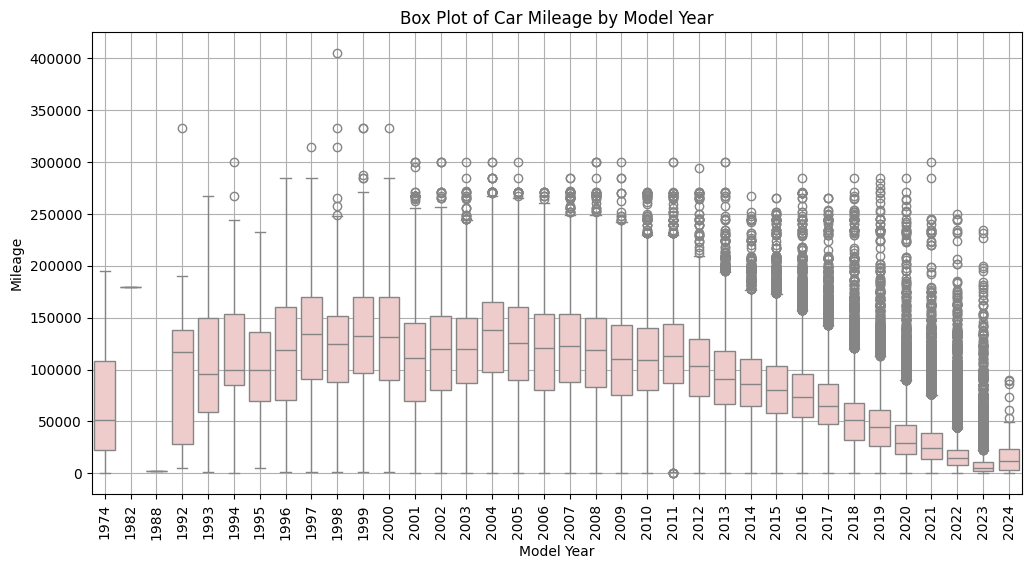

In [127]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="model_year", y="milage", data=combined, color=retro_palette[0])
plt.title("Box Plot of Car Mileage by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Mileage")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Looks better

We need to fill some missed values, I will do it the same way as I worked with outlayers

In [128]:
median_by_year = combined.groupby("model_year")["milage"].transform("median")

combined["milage"] = combined["milage"].fillna(median_by_year)

combined["milage"].isna().sum()

0

In [129]:
numeral.append("milage")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">5. Fuel type</div>

In [130]:
combined["fuel_type"].value_counts(dropna=False)

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
NaN                 8466
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [131]:
combined[combined["fuel_type"].isna()]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train,model_general
11,11,Tesla,Model S P100D,2015,81500.0,NaN,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,Yes,19000.0,Y,Model
32,32,Tesla,Model S P100D,2018,30300.0,NaN,518.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,Yes,64000.0,Y,Model
51,51,Tesla,Model 3 Long Range,2020,38360.0,NaN,Dual Motor - Standard,Automatic,White,Black,None reported,NaN,59598.0,Y,Model
52,52,Tesla,Model X 75D,2021,88000.0,NaN,518.0HP Electric Motor Electric Fuel System,1-Speed A/T,Black,Black,None reported,Yes,53600.0,Y,Model
161,161,Tesla,Model S Long Range,2021,9500.0,NaN,670.0HP Electric Motor Electric Fuel System,A/T,White,Beige,None reported,Yes,89999.0,Y,Model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313955,313955,Rivian,R1S Adventure Package,2023,9000.0,NaN,835.0HP Electric Motor Electric Fuel System,A/T,Red,White,None reported,Yes,NaN,N,R1S
314063,314063,Tesla,Model 3 Long Range,2018,42094.0,NaN,271.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,NaN,N,Model
314201,314201,Tesla,Model S 100D,2018,58000.0,NaN,518.0HP Electric Motor Electric Fuel System,1-Speed A/T,Gray,Black,None reported,Yes,NaN,N,Model
314210,314210,Tesla,Model 3 Long Range,2019,69548.0,NaN,Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes,NaN,N,Model


Looks like NaN are electric cars

In [132]:
combined[combined["fuel_type"] == "not supported"].head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train,model_general
4823,4823,Chevrolet,Suburban LT,2011,109646.0,not supported,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Beige,None reported,Yes,18998.0,Y,Suburban
18000,18000,Porsche,Camaro 2SS,2015,67000.0,not supported,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,11500.0,Y,Camaro
19182,19182,Nissan,Mirai Limited,2000,131000.0,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Silver,Black,None reported,Yes,5000.0,Y,Mirai
27199,27199,Subaru,Outback 2.5i Limited,2017,116000.0,not supported,175.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,CVT Transmission,Gray,Black,At least 1 accident or damage reported,Yes,27499.0,Y,Outback
33030,33030,Nissan,Mirai Limited,2009,137333.0,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,12999.0,Y,Mirai


It's possible to fill the data from engine feature

In [133]:
combined["engine"].head(10)

0         172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
1         252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel
2    320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
3         420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel
4         208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
5         252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
6        333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel
7    355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
8                      2.7L V6 24V PDI DOHC Twin Turbo
9    425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
Name: engine, dtype: object

In [134]:
def extract_fuel_type(engine_str):
    if pd.isna(engine_str):
        return np.nan
    engine_str = engine_str.lower()
    if "electric" in engine_str:
        return "Electric"
    if "diesel" in engine_str:
        return "Diesel"
    if "flex fuel" in engine_str:
        return "E85 Flex Fuel"
    if "gasoline" in engine_str:
        return "Gasoline"
    if "hybrid" in engine_str:
        return "Hybrid"
    if "plug-in hybrid" in engine_str:
        return "Plug-In Hybrid"
    return "not supported"


combined["fuel_type"] = combined["fuel_type"].replace("-", np.nan)
combined["fuel_type"] = combined["fuel_type"].replace("not supported", np.nan)
combined["fuel_type"] = combined["fuel_type"].fillna(
    combined["engine"].apply(extract_fuel_type)
)


combined["fuel_type"].value_counts()

fuel_type
Gasoline          276562
Hybrid             11509
E85 Flex Fuel       8932
Electric            8111
Diesel              6644
–                   1319
Plug-In Hybrid       858
not supported        288
Name: count, dtype: int64

In [135]:
combined[combined["fuel_type"] == "–"].head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train,model_general
532,532,Dodge,Challenger R/T Scat Pack,2021,35000.0,–,–,8-Speed A/T,Blue,Gray,None reported,Yes,48000.0,Y,Challenger
1155,1155,Ford,Mustang GT Premium,2017,143600.0,–,–,6-Speed M/T,White,Black,At least 1 accident or damage reported,Yes,31000.0,Y,Mustang
1307,1307,Toyota,Land Cruiser Base,1994,138033.0,–,–,A/T,Green,Beige,None reported,Yes,11999.0,Y,Land
1362,1362,Ford,Mustang EcoBoost Premium,2016,43000.0,–,–,A/T,Blue,Black,None reported,Yes,15500.0,Y,Mustang
1741,1741,Chevrolet,Protege DX,1993,94200.0,–,–,A/T,Red,Gray,None reported,Yes,7599.0,Y,Protege


In [136]:
combined[combined["fuel_type"] == "not supported"]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,is_train,model_general
51,51,Tesla,Model 3 Long Range,2020,38360.0,not supported,Dual Motor - Standard,Automatic,White,Black,None reported,NaN,59598.0,Y,Model
7233,7233,Tesla,Model Y Long Range,2021,35315.0,not supported,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,47598.0,Y,Model
7362,7362,Tesla,Model S 85D,2015,75897.0,not supported,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,18998.0,Y,Model
7807,7807,Tesla,Model 3 Long Range,2020,30455.0,not supported,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,39798.0,Y,Model
8879,8879,Audi,Q5 S line Premium Plus,2016,35315.0,not supported,2.0 Liter TFSI,Automatic,Daytona Gray,Black,At least 1 accident or damage reported,NaN,17498.0,Y,Q5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307920,307920,Tesla,Model Y Long Range,2020,43875.0,not supported,Dual Motor - Standard,Automatic,Deep Blue Metallic,Black,None reported,NaN,NaN,N,Model
308824,308824,Tesla,Model S 75D,2017,51808.0,not supported,5.0L V8 32V PDI DOHC,1-Speed Automatic,Black,Black,None reported,NaN,NaN,N,Model
311266,311266,Tesla,Model Y Long Range,2021,78816.0,not supported,Dual Motor - Standard,Automatic,Agate Black Metallic,Black,None reported,NaN,NaN,N,Model
312319,312319,Ford,F-150 Lightning LARIAT,2020,18385.0,not supported,5.0L V8 32V PDI DOHC,1-Speed Automatic,Caspian Blue,Gray,NaN,NaN,NaN,N,F-150


In [137]:
combined["fuel_type"] = combined["fuel_type"].replace("–", "no_data")
combined["fuel_type"] = combined["fuel_type"].replace("not supported", "no_data")

In [138]:
combined["fuel_type"].value_counts()

fuel_type
Gasoline          276562
Hybrid             11509
E85 Flex Fuel       8932
Electric            8111
Diesel              6644
no_data             1607
Plug-In Hybrid       858
Name: count, dtype: int64

In [139]:
categorical.append("fuel_type")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">6. Engine</div>

In [140]:
combined["engine"].isna().sum()

0

In [141]:
combined["engine"].value_counts().tail(20)

engine
115.0HP Electric Motor Electric Fuel System            6
164.0HP 1.4L 4 Cylinder Engine Gasoline Fuel           6
543.0HP 5.5L 12 Cylinder Engine Gasoline Fuel          6
1.6L I4 16V GDI DOHC                                   6
3.8L V6 12V MPFI OHV                                   5
250.0HP 2.7L V6 Cylinder Engine Gasoline Fuel          5
443.0HP 4.4L 8 Cylinder Engine Gasoline Fuel           5
139.0HP 1.6L 4 Cylinder Engine Gas/Electric Hybrid     5
322.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas    5
266.0HP 2.5L 4 Cylinder Engine Plug-In Electric/Gas    5
226.0HP 1.6L 4 Cylinder Engine Gas/Electric Hybrid     4
141.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           4
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid     4
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability    4
177.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas    4
70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel            3
111.0HP Electric Motor Electric Fuel System            3
139.0HP 1.6L 4 Cylinder 

I want to try use this feature as text for catboost

In [142]:
# text = ["engine"]

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">7. Transmission</div>

In [143]:
combined["transmission"].isna().sum()

0

In [144]:
combined["transmission"].value_counts()

transmission
A/T                                                   83036
8-Speed A/T                                           34586
Transmission w/Dual Shift Mode                        32079
6-Speed A/T                                           30105
6-Speed M/T                                           19863
7-Speed A/T                                           18498
Automatic                                             17866
8-Speed Automatic                                     13977
10-Speed A/T                                          13347
9-Speed A/T                                            6450
5-Speed A/T                                            5458
10-Speed Automatic                                     5268
6-Speed Automatic                                      4690
4-Speed A/T                                            4212
5-Speed M/T                                            4048
9-Speed Automatic                                      3878
CVT Transmission           

It's possible to simplify this feature

In [145]:
def simplify_transmission(transmission):
    transmission = transmission.lower()
    if "manual" in transmission or "mt" in transmission:
        return "Manual"
    elif "cv" in transmission or "variable" in transmission:
        return "CVT"
    elif "automatic" in transmission or "a/t" in transmission or "at" in transmission:
        return "Automatic"
    elif "dct" in transmission:
        return "DCT"
    elif "overdrive" in transmission:
        return "Overdrive"
    else:
        return "Other"


combined["simplified_transmissions"] = combined["transmission"].apply(
    simplify_transmission
)

combined["simplified_transmissions"].value_counts()

simplified_transmissions
Automatic    249250
Other         59068
CVT            4848
Manual          777
Overdrive       280
Name: count, dtype: int64

In [146]:
categorical.append("simplified_transmissions")
categorical.append("transmission")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">8. Ext color</div>

In [147]:
combined["ext_col"].value_counts().tail(15)

ext_col
Silky Silver                          15
Ironman Silver                        14
Horizon Blue                          14
Granite                               14
Pure White                            13
Frozen White                          13
Tempest                               12
Dark Gray Metallic                    12
Thunder Gray                          11
Aventurine Green Metallic             10
Granite Crystal Metallic Clearcoat     8
BLUE                                   7
Nautical Blue Pearl                    7
Mango Tango Pearlcoat                  5
GT SILVER                              5
Name: count, dtype: int64

In [148]:
combined["ext_col"].value_counts().head(15)

ext_col
Black                     81028
White                     73040
Gray                      42193
Silver                    28343
Blue                      24272
Red                       16548
Green                      4556
Gold                       2838
Brown                      1920
Orange                     1896
Beige                      1820
Yellow                     1603
Bright White Clearcoat     1263
Diamond Black              1170
Agate Black Metallic       1056
Name: count, dtype: int64

I want to try generalize the small groups

In [149]:
import pandas as pd


def categorize_color(color):
    color = color.lower()
    if "metallic" in color:
        return "Metallic"
    elif "white" in color:
        return "White"
    elif "blue" in color:
        return "Blue"
    elif "black" in color:
        return "Black"
    elif "gray" in color or "grey" in color:
        return "Gray"
    elif "silver" in color:
        return "Silver"
    elif "red" in color:
        return "Red"
    elif "green" in color:
        return "Green"
    elif "gold" in color:
        return "Gold"
    elif "brown" in color:
        return "Brown"
    elif "orange" in color:
        return "Orange"
    elif "beige" in color:
        return "Beige"
    elif "yellow" in color:
        return "Yellow"
    elif "purple" in color:
        return "Purple"
    elif "pink" in color:
        return "Pink"
    else:
        return "Other"


combined["ext_color_groups"] = combined["ext_col"].apply(categorize_color)
combined["ext_color_groups"].value_counts()

ext_color_groups
Black       85712
White       79225
Gray        43521
Silver      29269
Blue        25041
Red         18814
Metallic    14127
Green        4891
Other        2889
Gold         2838
Brown        1920
Orange       1913
Beige        1820
Yellow       1634
Purple        577
Pink           32
Name: count, dtype: int64

In [150]:
categorical.append("ext_color_groups")
categorical.append("ext_col")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">9. Int_col</div>

In [151]:
combined["int_col"].value_counts()

int_col
Black           179287
Beige            40990
Gray             35381
Brown             9721
Red               8641
                 ...  
WHITE               14
Carbon Black        12
Bianco Polar        11
Cobalt Blue          9
ORANGE               6
Name: count, Length: 156, dtype: int64

Do the same as for the ext_col

In [152]:
combined["int_color_groups"] = combined["int_col"].apply(categorize_color)
combined["int_color_groups"].value_counts()

int_color_groups
Black     187713
Beige      41577
Gray       36027
Other      16774
Brown      10044
Red         9231
White       8093
Orange      1618
Blue        1415
Silver       735
Gold         567
Green        340
Yellow        89
Name: count, dtype: int64

I will not include the raw feature, because I think groups will work better

In [153]:
categorical.append("int_color_groups")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">9. Accident</div>

In [154]:
combined["accident"].value_counts()

accident
None reported                             240777
At least 1 accident or damage reported     69362
Name: count, dtype: int64

I want to make it binary with Yes and No

In [155]:
combined["accident"] = combined["accident"].map(
    {"None reported": "No", "At least 1 accident or damage reported": "Yes"}
)

combined["accident"].value_counts()

accident
No     240777
Yes     69362
Name: count, dtype: int64

In [156]:
combined["accident"].isna().sum()

4084

In [157]:
combined["accident"] = combined["accident"].fillna("No")

In [158]:
categorical.append("accident")

### <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 18px;padding: 3px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">10. Clean_title</div>

In [159]:
combined["clean_title"].value_counts(dropna=False)

clean_title
Yes    278565
NaN     35658
Name: count, dtype: int64

In [160]:
combined["clean_title"] = combined["clean_title"].fillna("No")

In [161]:
combined["clean_title"].value_counts(dropna=False)

clean_title
Yes    278565
No      35658
Name: count, dtype: int64

In [162]:
categorical.append("clean_title")

## <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 24px;padding: 10px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">3. Preprocessing</div>

In [163]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        314223 non-null  int64  
 1   brand                     314223 non-null  object 
 2   model                     314223 non-null  object 
 3   model_year                314223 non-null  int64  
 4   milage                    314223 non-null  float64
 5   fuel_type                 314223 non-null  object 
 6   engine                    314223 non-null  object 
 7   transmission              314223 non-null  object 
 8   ext_col                   314223 non-null  object 
 9   int_col                   314223 non-null  object 
 10  accident                  314223 non-null  object 
 11  clean_title               314223 non-null  object 
 12  price                     188533 non-null  float64
 13  is_train                  314223 non-null  o

Splitting train and test

In [164]:
train = combined[combined["is_train"] == "Y"].drop(columns=["is_train"])
test = combined[combined["is_train"] == "N"].drop(columns=["is_train"])

In [165]:
train.shape

(188533, 17)

In [166]:
test.shape

(125690, 17)

In [167]:
categorical

['brand',
 'model_general',
 'fuel_type',
 'simplified_transmissions',
 'transmission',
 'ext_color_groups',
 'ext_col',
 'int_color_groups',
 'accident',
 'clean_title']

In [168]:
numeral

['model_year', 'milage']

In [169]:
# text

In [170]:
X = categorical + numeral
y = ["price"]

In [171]:
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_general,simplified_transmissions,ext_color_groups,int_color_groups
0,0,MINI,Cooper S Base,2007,213000.0,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,No,Yes,4200.0,Cooper,Automatic,Yellow,Gray
1,1,Lincoln,LS V8,2002,143250.0,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,Yes,Yes,4999.0,LS,Automatic,Silver,Beige
2,2,Chevrolet,Silverado 2500 LT,2002,136731.0,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,No,Yes,13900.0,Silverado,Automatic,Blue,Gray
3,3,Genesis,G90 5.0 Ultimate,2017,19500.0,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,No,Yes,45000.0,G90,Other,Black,Black
4,4,Mercedes-Benz,Metris Base,2021,7388.0,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,No,Yes,97500.0,Metris,Automatic,Black,Beige
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000.0,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,No,Yes,27500.0,Escalade,Other,White,Beige
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600.0,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,Yes,Yes,30000.0,AMG,Automatic,White,Black
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650.0,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,No,Yes,86900.0,AMG,Automatic,White,Black
188531,188531,Audi,S5 3.0T Prestige,2022,13895.0,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,No,No,84900.0,S5,Automatic,Gray,Black


In [172]:
phik_overview = train[X + y].phik_matrix()
phik_corr = phik_overview.round(2)

interval columns not set, guessing: ['model_year', 'milage', 'price']


In [173]:
phik_corr["price"].sort_values(ascending=False)

price                       1.00
ext_col                     0.19
model_general               0.17
brand                       0.13
transmission                0.12
milage                      0.07
ext_color_groups            0.06
int_color_groups            0.05
accident                    0.05
model_year                  0.05
clean_title                 0.03
simplified_transmissions    0.02
fuel_type                   0.01
Name: price, dtype: float64

<Axes: >

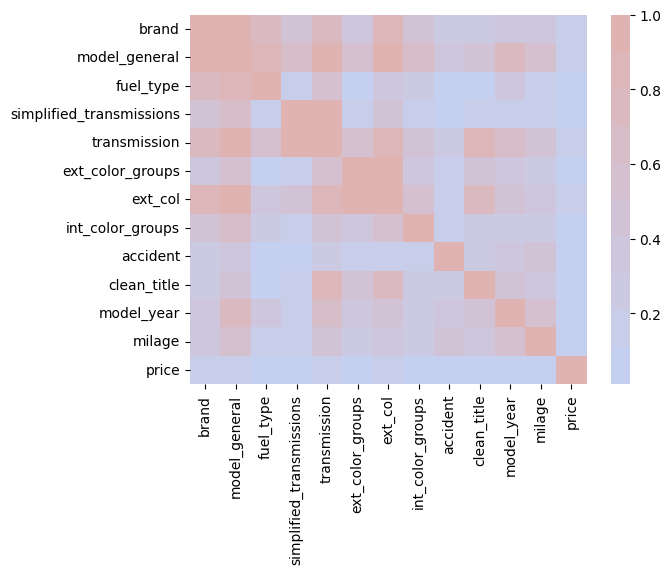

In [174]:
sns.heatmap(phik_overview.round(2), cmap=cmap)

## <div style="background-color: #d4e1e6;font-family: Georgia, serif;color: #3f475e;font-size: 24px;padding: 10px;border: 1px solid #b0bec5;border-radius: 8px;backdrop-filter: blur(2px);text-shadow: 0px 1px 1px rgba(0, 0, 0, 0.1);margin-bottom: 20px;">4. Modelling</div>

In [175]:
params = {
    "random_seed": 42,
    "verbose": 100,
    "loss_function": "RMSE",
    "early_stopping_rounds": 200,
    "eval_metric": "RMSE",
}


train_train, train_val = train_test_split(train, train_size=0.8, random_state=42)


train_first_pool = Pool(
    data=train_train[X], label=train_train[y], cat_features=categorical
)

val_first_pool = Pool(train_val[X], label=train_val[y], cat_features=categorical)

model = CatBoostRegressor(**params)

model.fit(train_first_pool, eval_set=val_first_pool)

Learning rate set to 0.111922
0:	learn: 78929.4519584	test: 73592.5185172	best: 73592.5185172 (0)	total: 38.8ms	remaining: 38.8s
100:	learn: 73622.0473144	test: 68349.5648807	best: 68349.5648807 (100)	total: 2.15s	remaining: 19.1s
200:	learn: 72998.1413836	test: 68229.1193512	best: 68228.5735333 (194)	total: 4.13s	remaining: 16.4s
300:	learn: 72444.8699539	test: 68245.6025442	best: 68224.8857083 (212)	total: 6.18s	remaining: 14.4s
400:	learn: 71841.2780941	test: 68263.6764916	best: 68224.8857083 (212)	total: 8.28s	remaining: 12.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 68224.88571
bestIteration = 212

Shrink model to first 213 iterations.


In [176]:
# params = {
#     "random_seed": 42,
#     "verbose": 100,
#     "loss_function": "RMSE",
#     "early_stopping_rounds": 200,
#     "eval_metric": "RMSE",
# }


# train_train, train_val = train_test_split(train, train_size=0.8, random_state=42)


# train_first_pool = Pool(
#     data=train_train[X],
#     label=train_train[y],
#     cat_features=categorical,
#     text_features=text,
# )

# val_first_pool = Pool(
#     train_val[X], label=train_val[y], cat_features=categorical, text_features=text
# )

# model = CatBoostRegressor(**params)

# model.fit(train_first_pool, eval_set=val_first_pool)

In [177]:
# Learning rate set to 0.111922
# 0:	learn: 78884.6388885	test: 73534.8973959	best: 73534.8973959 (0)	total: 53.8ms	remaining: 53.7s
# 100:	learn: 72131.0907900	test: 68295.8727086	best: 68288.3620719 (95)	total: 4.31s	remaining: 38.4s
# 200:	learn: 70863.2384601	test: 68430.5826315	best: 68288.3620719 (95)	total: 8.53s	remaining: 33.9s
# Stopped by overfitting detector  (200 iterations wait)

# bestTest = 68288.36207
# bestIteration = 95

# Shrink model to first 96 iterations.

In [178]:
X

['brand',
 'model_general',
 'fuel_type',
 'simplified_transmissions',
 'transmission',
 'ext_color_groups',
 'ext_col',
 'int_color_groups',
 'accident',
 'clean_title',
 'model_year',
 'milage']

In [179]:
X = [
    "brand",
    "model_general",
    "fuel_type",
    "simplified_transmissions",
    "transmission",
    "ext_color_groups",
    "ext_col",
    "int_color_groups",
    "accident",
    "clean_title",
    "model_year",
    "milage",
]

In [180]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 3, 10),
#         "border_count": trial.suggest_int("border_count", 5, 255),
#         "random_seed": 42,
#         "verbose": 100,
#         "loss_function": "RMSE",
#         "eval_metric": "RMSE",
#         "early_stopping_rounds": 200,
#     }

#     train_train, train_val = train_test_split(train, train_size=0.8, random_state=42)

#     train_first_pool = Pool(
#         data=train_train[X],
#         label=train_train[y],
#         cat_features=categorical,
#         text_features=text,
#     )
#     val_first_pool = Pool(
#         train_val[X], label=train_val[y], cat_features=categorical, text_features=text
#     )

#     model = CatBoostRegressor(**params)
#     model.fit(train_first_pool, eval_set=val_first_pool, use_best_model=True)

#     y_pred = model.predict(train_val[X])
#     rmse = np.sqrt(mean_squared_error(train_val[y], y_pred))

#     return rmse


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=15)

# print("Best parameters:", study.best_params)
# print("Best RMSE score:", study.best_value)

In [181]:
# Best params: {'iterations': 358,
#  'depth': 10,
#  'learning_rate': 0.12835731919455495,
#  'l2_leaf_reg': 10,
#  'border_count': 167}

In [182]:
pred = model.predict(test[X])

In [183]:
test["price"] = pred

test[["id", "price"]].to_csv("submission.csv", index=False)